# Training Results

Present notebook compares the performance of training a **PQC** when uses as *loss function* the standard *MSE* versus our $R_{L^2, \bar{L}^2}^{S_{\chi}}$ proposal.

For this comparison, we have generated data from a **BS CDF** (see *15_qml4var_DataSets.ipynb*) and used it for training the same **PQC** using the 2 aforementioned *loss function*. The used **PQC** was:

* *hardware_efficient_ansatz* function from **QQuantLib.qml4var.architectures** module.
* 2 qubits by feature
* 3 layers
* base_frecuency: 1.0833078115826873
* shift_feature: -1.6791271079531653


The training procedure was the same for the 2 losses:

* Number Of Epochs: 200
* Number Of shots : 0
* Adam Optimizer:
    * learning_rate : 0.1
    * $\beta_1$ : 0.9
    * $\beta_1$ : 0.999
    
For each loss function, 100 training sessions were conducted, and the final weights were recorded for each session.

In the **misc/notebooks/qml4var_data** folder of the *FinancialApplications* software application the followings files can be found:

* *2024_10_04_BS_training.csv*: CSV file with the training data. The x values were obtained by sampling from a **BS CDF** and the corresponding y values were obtained from the *empirical distribution function* (as explained *15_qml4var_DataSets.ipynb*)
* 2024_10_04_BS_training.csv*: CSV with the testing data. This is the actual **BS CDF** over the whole domain-
* *data.json*: JSON file with the information for generating the datasets.
* *pqc.json*: JSON file with the information for building the **PQC**
* *optimizer_info.json*: JSON file with the training information.
* *mse_loss_function.csv*: CSV file with the information for the 100 pieces of training using the *MSE* loss function.
* *qdml_loss_function.csv*: CSV file with the information for the 100 trainings using the $R_{L^2, \bar{L}^2}^{S_{\chi}}$ loss function.


In [ ]:
import json
import sys
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
sys.path.append("../../")

## 1. Load the Data

First the complete training and testing data will be loaded.

In [ ]:
from QQuantLib.qml4var.data_utils import get_dataset

In [ ]:
data_file = "qml4var_data/2024_10_04_BS"
x_train, y_train, x_test, y_test = get_dataset(data_file)

In [ ]:
plt.plot(x_test, y_test, '-')
plt.plot(x_train, y_train, 'o')
plt.legend(["Testing Data", "Training Data"])

## 2 Get the PQC

Now the architecture will be loaded.

In [ ]:
from QQuantLib.qml4var.architectures import hardware_efficient_ansatz, \
    z_observable, normalize_data

In [ ]:
pqc_json_file = "qml4var_data/pqc.json"
with open(pqc_json_file) as json_file:
    pqc_info = json.load(json_file)
print(pqc_info)

In [ ]:
# build the PQC
pqc, weigths_names, features_names = hardware_efficient_ansatz(**pqc_info)
observable = z_observable(**pqc_info)
circuit = pqc.to_circ()
circuit.display()

## 3. Get QPU info

In [ ]:
from QQuantLib.utils.benchmark_utils import combination_for_list

In [ ]:
json_qpu = "../../benchmark/qml4var/JSONs/qpu_ideal.json"
with open(json_qpu) as json_file:
    qpu_dict = json.load(json_file)
qpu_list = combination_for_list(qpu_dict)
qpu_dict = qpu_list[0]
print(qpu_dict)

## 4. PQC Evaluation Workflow

Here we build the PQC for evaluation. Given weights, the function evaluates the **PQC** for the input weights and data.

In [ ]:
from QQuantLib.qml4var.myqlm_workflows import workflow_for_cdf

In [ ]:
def pqc_evaluation(weights, x_train, x_test, dask_client=None, **input_dict):
    train_dataset_cdf = lambda w_: workflow_for_cdf(
        w_,
        x_train,
        dask_client=dask_client,
        **input_dict
    )  
    test_dataset_cdf = lambda w_: workflow_for_cdf(
        w_,
        x_test,
        dask_client=dask_client,
        **input_dict
    )
    weights_list = list(weights.values)
    yp_train = train_dataset_cdf(weights_list)['y_predict_cdf']
    yp_test = test_dataset_cdf(weights_list)['y_predict_cdf']
    return yp_train, yp_test 

In [ ]:
input_dict = {
    "pqc" : pqc, 
    "observable" : observable, 
    "weights_names" : weigths_names,
    "features_names" : features_names,
    "nbshots" : 0,
    "qpu_info" : qpu_dict,
}    

## 5. Trained weights using MSE

The *mse_loss_function.csv* contains the info of the 100 trainings with **MSE** as the *loss function*

In [ ]:
mse = pd.read_csv(
    "qml4var_data/mse_loss_function.csv",
    sep=";"
)

We can plug some weights into the *pqc_evaluation* function and get the prediction for training and testing data for the **MSE**:

In [ ]:
weights_mse = mse[weigths_names].iloc[0]

In [ ]:
yp_train, yp_test  =pqc_evaluation(weights_mse, x_train, x_test, **input_dict)

In [ ]:
plt.plot(x_train, y_train, 'o')
plt.plot(x_train, yp_train, 'o')
plt.legend(["Training Data", "Prediction"])
plt.title("MSE Loss. Trianing Data")

In [ ]:
plt.plot(x_test, y_test, '-')
plt.plot(x_test, yp_test, 'o')
plt.legend(["Testing Data", "Prediction"])
plt.title("MSE Loss. Testing Data")

## 6. Trained weights using $R_{L^2, \bar{L}^2}^{S_{\chi}}$

The *qdml_loss_function.csv* contains the info of the 100 trainings with $R_{L^2, \bar{L}^2}^{S_{\chi}}$ as the *loss function*

In [ ]:
qdml = pd.read_csv(
    "qml4var_data/qdml_loss_function.csv",
    sep=";"
)

We can plug some weights into the *pqc_evaluation* function and get the prediction for training and testing data for the $R_{L^2, \bar{L}^2}^{S_{\chi}}$ :

In [ ]:
weights_qdml = qdml[weigths_names].iloc[0]

In [ ]:
yp_train, yp_test  =pqc_evaluation(
    weights_qdml, x_train, x_test, **input_dict)

In [ ]:
plt.plot(x_train, y_train, 'o')
plt.plot(x_train, yp_train, 'o')
plt.legend(["Training Data", "Prediction"])
plt.title(r"$R_{L^2, \bar{L}^2}^{S_{\chi}}$. Training Data")

In [ ]:
plt.plot(x_test, y_test, '-')
plt.plot(x_test, yp_test, 'o')
plt.legend(["Testing Data", "Prediction"])
plt.title(r"$R_{L^2, \bar{L}^2}^{S_{\chi}}$. Testing Data")

As can be seen the performance of the **PQC** trained using the $$R_{L^2, \bar{L}^2}^{S_{\chi}}$$ is better than the trained with the **MSE**:

## 7 Comparison of all trainings

We can compare the performance over all the trainings for the 2 different **loss functions**.

In [ ]:
Predict_Train_mse = []
Predict_Test_mse = []
for i, w in mse[weigths_names].iterrows():
    train_p, test_p = pqc_evaluation(
        w, x_train, x_test, **input_dict
    )
    Predict_Train_mse.append(train_p)
    Predict_Test_mse.append(test_p)

We want to evaluate the model in the complete domain so we are going to use the testing data.

In [ ]:
final_mse = pd.DataFrame(Predict_Test_mse).T

In [ ]:
color = 'orange'
plt.plot(x_test, y_test, '-')
plt.plot(x_test, final_mse.mean(axis=1), '-')
plt.fill_between(
    x_test[:,0], 
    final_mse.quantile(q=0.25, axis=1), 
    final_mse.quantile(q=0.75, axis=1),
    color = color, alpha=0.5)
plt.legend(["Testing Data", "Mean Prediction"])
plt.title("MSE Loss. Testing Data")

In [ ]:
Predict_Train_qdml = []
Predict_Test_qdml = []
for i, w in qdml[weigths_names].iterrows():
    train_p, test_p = pqc_evaluation(
        w, x_train, x_test, **input_dict
    )
    Predict_Train_qdml.append(train_p)
    Predict_Test_qdml.append(test_p)

In [ ]:
# Plot Mean and Quartiles
final_qdml = pd.DataFrame(Predict_Test_qdml).T
color = 'orange'
plt.plot(x_test, y_test, '-')
plt.plot(x_test, final_qdml.mean(axis=1), '-')
plt.fill_between(
    x_test[:,0], 
    final_qdml.quantile(q=0.25, axis=1), 
    final_qdml.quantile(q=0.75, axis=1),
    color = color, alpha=0.5)
plt.legend(["Testing Data", "Mean Prediction"])
plt.title(r"$R_{L^2, \bar{L}^2}^{S_{\chi}}$. Testing Data")

Performance for **PQC** trained using **MSE**

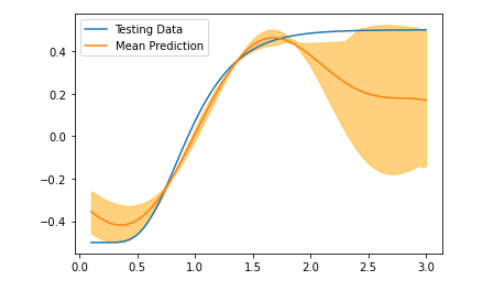

Performance for **PQC**s trained using $R_{L^2, \bar{L}^2}^{S_{\chi}}$ loss

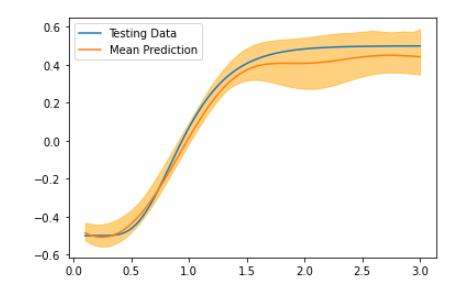

As can be see, under the same training conditions **PQC**s trained using $R_{L^2, \bar{L}^2}^{S_{\chi}}$ has a better performance over the complete domain than the trained using **MSE**.